# Assessment 1: Stock Volatility Predictiom

## Mathias H. Morgan

## 35087056

### Import Libraries

In [ ]:
#TODO: Adjust train path

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [411]:
stockVolDf = pd.read_csv('A1_stock_volatility_labeled.csv')

## Exploratory Data Analysis

In [412]:
stockVolDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13486 entries, 0 to 13485
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       13486 non-null  object 
 1   Open                       13486 non-null  float64
 2   Close                      13486 non-null  float64
 3   High                       13486 non-null  float64
 4   Low                        13486 non-null  float64
 5   Volume                     13486 non-null  int64  
 6   Amount                     13486 non-null  float64
 7   Avg_Price                  13486 non-null  float64
 8   Return                     13486 non-null  float64
 9   Volatility                 13486 non-null  float64
 10  Revenue                    13486 non-null  float64
 11  Net Income                 13486 non-null  float64
 12  Gross Profit               13486 non-null  float64
 13  EPS                        13486 non-null  flo

In [ ]:
print("--- Dataset Overview ---")
stockVolDfCoutnt = stockVolDf.shape[0]
print(f"Number of training data rows: {stockVolDfCoutnt}")

--- Dataset Overview ---
Number of training data rows: 13,486


In [414]:
print("--- Checking for missing missing values ---\n")
print(f"Missing labels in stockVolDf: \n{stockVolDf.isna().sum()}")

--- Checking for missing missing values ---

Missing labels in stockVolDf: 
Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64


In [415]:
print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrain = stockVolDf.eq('').sum()
print(f"Number of empty/whitespace-only reviews: {emptyCountTrain}...")


--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64...


In [416]:
print("\n--- Checking for duplicate reviews ---")
duplicateRowCount = stockVolDf.duplicated().sum()
print(f"Number of duplicate reviews in test data: {duplicateRowCount}...")


--- Checking for duplicate reviews ---
Number of duplicate reviews in test data: 0...


In [417]:
stockVolDf['Date'] = pd.to_datetime(stockVolDf['Date'])

## Transformations

In [418]:
# Apply log transformation to Volatility
stockVolDf['Volatility_Log'] = np.log1p(stockVolDf['Volatility'])

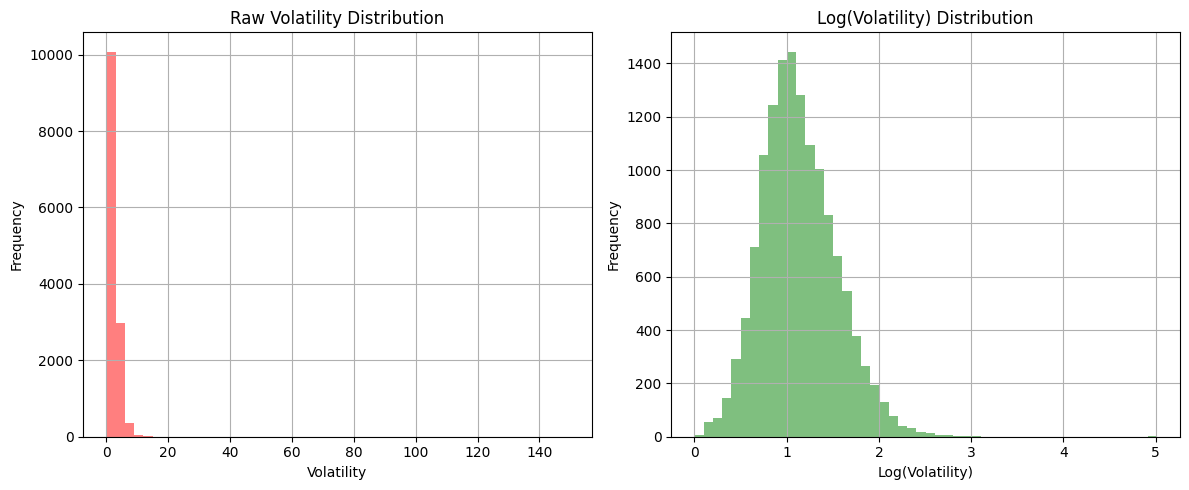

In [419]:
# Visualize distribution before and after
plt.figure(figsize=(12, 5))

# Create pre log-transformation histogram
plt.subplot(1, 2, 1)
stockVolDf['Volatility'].hist(bins=50, alpha=0.5, color='red')
plt.title('Raw Volatility Distribution')
plt.xlabel('Volatility')
plt.ylabel('Frequency')

# Create post log-transformation histogram
plt.subplot(1, 2, 2)
stockVolDf['Volatility_Log'].hist(bins=50, alpha=0.5, color='green')
plt.title('Log(Volatility) Distribution')
plt.xlabel('Log(Volatility)')
plt.ylabel('Frequency')

# Display plots
plt.tight_layout()
plt.show()


In [420]:
print(stockVolDf[['Volatility', 'Volatility_Log']].describe())

         Volatility  Volatility_Log
count  13486.000000    13486.000000
mean       2.396125        1.132988
std        2.033964        0.404403
min        0.000000        0.000000
25%        1.345456        0.852480
50%        1.980023        1.091931
75%        3.001239        1.386604
max      149.476478        5.013807


In [ ]:
# Extract month
stockVolDf['month'] = stockVolDf['Date'].dt.month

# Cyclical encoding
stockVolDf['month_sin'] = np.sin(2 * np.pi * stockVolDf['month'] / 12)
stockVolDf['month_cos'] = np.cos(2 * np.pi * stockVolDf['month'] / 12)

# Drop Month
stockVolDf = stockVolDf.drop('month', axis=1)

In [422]:
# 3 lagged features for log volatility
for lag in [1, 2, 3]:
    stockVolDf[f'vol_lag{lag}'] = stockVolDf.groupby('Stock')['Volatility_Log'].shift(lag)

In [ ]:
# Features to lag from trading
tradingLag = ['Volume', 'Amount', 'Return', 'Volatility_Log']
for col in tradingLag:
    for lag in [1, 2, 3]:  # 1-3 lags for monthly features
        stockVolDf[f'{col}_lag{lag}'] = stockVolDf.groupby('Stock')[col].shift(lag)

In [ ]:
# Features to lag from financial data
financialToLag = [
    'Revenue', 'Net Income', 'Gross Profit', 'EPS',
    'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents',
    'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow']

for col in financialToLag:
    stockVolDf[f'{col}_lag1'] = stockVolDf.groupby('Stock')[col].shift(1)  # 1 lag for quarterly (updates every 3 months)

In [ ]:
# Drop rows with NaN in any lagged column
lagCols = [f'vol_lag{lag}' for lag in [1,2,3]] + [f'{col}_lag{lag}' for col in tradingLag for lag in [1,2,3]] + [f'{col}_lag1' for col in financialToLag]
stockVolDf = stockVolDf.dropna(subset=lagCols).reset_index(drop=True)
print(lagCols)

['vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']


In [426]:
coltoMove = 'Volatility'
cols = stockVolDf.columns.tolist()
cols.remove(coltoMove)
cols.append(coltoMove)
stockVolDf = stockVolDf[cols]

In [427]:
def separate_feature_target_cols(churnDataFrame: pd.DataFrame) -> tuple[list,str]:
    featureCols = churnDataFrame.columns[:-1] # seperate feature columns
    featureCols = [col for col in featureCols if col not in ['Volatility_Log', 'Date']]
    targetCol = churnDataFrame.columns[-1] # seperate target column
    print(f"All Feature Columns: {featureCols}")
    print(f"Target Column: {targetCol}")
    return featureCols, targetCol

# Separate features and target
featureCols, targetCol = separate_feature_target_cols(stockVolDf)

All Feature Columns: ['Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price', 'Return', 'Revenue', 'Net Income', 'Gross Profit', 'EPS', 'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents', 'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow', 'Stock', 'month_sin', 'month_cos', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']
Target Column: Volatility


In [ ]:
ma_windows = [3, 6]
for w in ma_windows:
    stockVolDf[f'vol_log_ma_{w}'] = (
        stockVolDf.groupby('Stock')['Volatility_Log']
          .transform(lambda x: x.rolling(window=w, min_periods=1).mean())
    )
    stockVolDf[f'vol_log_ema_{w}'] = (
        stockVolDf.groupby('Stock')['Volatility_Log']
          .transform(lambda x: x.ewm(span=w, adjust=False).mean())
    )

trading_cols = ['Volume', 'Amount', 'Return']
for col in trading_cols:
    stockVolDf[f'{col}_ma_3'] = stockVolDf.groupby('Stock')[col].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

## Correlation analysis

In [429]:
# Select only numeric features + target
numericFeatures = [col for col in featureCols if stockVolDf[col].dtype in [np.float64, np.int64]]

# Compute correlation matrix
corrMatrix = stockVolDf[numericFeatures + [targetCol]].corr()
targetCorr = corrMatrix[targetCol].sort_values(ascending=False)

print("Top features positively correlated with Volatility_Log:")
print(targetCorr.head(10))
print("\nTop features negatively correlated with Volatility_Log:")
print(targetCorr.tail(10))

Top features positively correlated with Volatility_Log:
Volatility                  1.000000
Volatility_Log_lag3         0.529781
vol_lag3                    0.529781
Volatility_Log_lag1         0.526397
vol_lag1                    0.526397
Volatility_Log_lag2         0.514145
vol_lag2                    0.514145
Return                      0.199920
Investing Cash Flow         0.072667
Investing Cash Flow_lag1    0.071588
Name: Volatility, dtype: float64

Top features negatively correlated with Volatility_Log:
Gross Profit_lag1        -0.079577
Gross Profit             -0.079769
Revenue_lag1             -0.090385
Revenue                  -0.090673
Total Assets             -0.111249
Total Assets_lag1        -0.111390
Total Liabilities        -0.125903
Total Liabilities_lag1   -0.125929
EPS_lag1                 -0.158972
EPS                      -0.160059
Name: Volatility, dtype: float64


In [430]:
stockVolDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11647 entries, 0 to 11646
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            11647 non-null  datetime64[ns]
 1   Open                            11647 non-null  float64       
 2   Close                           11647 non-null  float64       
 3   High                            11647 non-null  float64       
 4   Low                             11647 non-null  float64       
 5   Volume                          11647 non-null  int64         
 6   Amount                          11647 non-null  float64       
 7   Avg_Price                       11647 non-null  float64       
 8   Return                          11647 non-null  float64       
 9   Revenue                         11647 non-null  float64       
 10  Net Income                      11647 non-null  float64       
 11  Gr

In [431]:
stockVolDf.to_csv('A1_stock_volatility_feature_engineered.csv', index=False)

# Modelling

In [432]:
def plot_top_features(importance_df, feature_col='feature', gain_col='gain', top_n=10):
    # Sort and select top features
    top_features = importance_df.sort_values(by=gain_col, ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features[feature_col], top_features[gain_col], color='skyblue')
    plt.xlabel('Information Gain')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features by Information Gain')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


## Light GBM Model

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits
LIGHT GBM RESULT
Best Params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 64, 'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
Validation RMSE: 0.343815

TOP FEATURES BY INFORMATION GAIN
                  Feature  Gain
            vol_log_ema_3  6351
                 vol_lag1  4537
                 vol_lag2  3569
            vol_log_ema_6  3146
             vol_log_ma_3  2823
              Return_ma_3  2390
                    Stock  2311
                 vol_lag3  2242
              Return_lag3  2154
             vol_log_ma_6  2124
                   Return  2077
              Return_lag1  1832
              Return_lag2  1760
                month_sin  1576
                month_cos  1450
      Volatility_Log_lag1   915
      Financing Cash Flow   885
                   Volume   871
Cash and Cash Equivalents   865
     

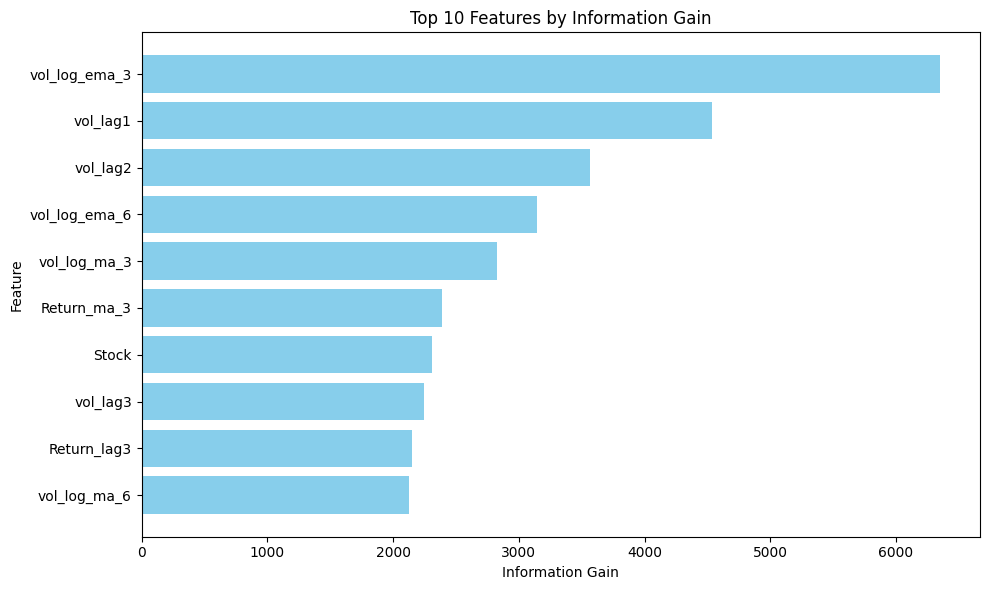

In [433]:
# -------------------------- 1. Load --------------------------
trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

# Feature / target separation
featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"

# -------------------------- 2. Time-Series Split --------------------------

allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[ trainDf["Date"].isin(valDates)].copy()

xTrain = trainSet[featureCols]
yTrain = trainSet[targetCol]
xVal   = valSet[featureCols]
yVal   = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. Hyperparameter Search --------------------------

paramDist = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.03],
    "num_leaves": [64, 128],
    "min_child_samples": [3, 5],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "reg_alpha": [0, 0.3],
    "reg_lambda": [0, 0.3],
    "max_depth": [-1, 10]
}

tscv = TimeSeriesSplit(n_splits=2)

lgb = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    categorical_feature="Stock",
    verbose=-1
)

randomSearch = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=paramDist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

randomSearch.fit(xTrain, yTrain)
bestModel = randomSearch.best_estimator_

# -------------------------- 4. Validation  --------------------------

valPredLog  = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
lgbRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print("LIGHT GBM RESULT")
print("="*50)
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {lgbRmse:.6f}")
print("="*50)

# -------------------------- 5. Feature Importance --------------------------

print("\n" + "="*50)
print("TOP FEATURES BY INFORMATION GAIN")
print("="*50)

# Re-fit best model on FULL training data (optional, but gives best importance)
bestModel.fit(xTrain, yTrain)  # already fitted in search, but safe to re-run

# Get feature importance (gain = total reduction in loss from splits on this feature)
importances = bestModel.feature_importances_
featureNames = xTrain.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': featureNames,
    'Gain': importances
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Show top 20
print(importance_df.head(20).to_string(index=False))

# -------------------------- 6. Volatility Prediction --------------------------

submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        row = trainDf[featureCols].median(numeric_only=True)
        row["Stock"] = stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")
xSubmit = latestDf[featureCols]

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date":       submitDate,
    "Stock":      submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 7. Prediction Results --------------------------

print(submission.head(10))

# -------------------------- 8. Plot Feature Information Gain --------------------------
plot_top_features(importance_df, feature_col='Feature', gain_col='Gain', top_n=10)


## Cat Boost Model

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits
CATBOOST REGRESSOR RESULT
Best Params: {'min_data_in_leaf': 10, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 0.5}
Validation RMSE: 0.204545

TOP FEATURES BY INFORMATION GAIN
            Feature      Gain
      vol_log_ema_3 71.483929
       vol_log_ma_3  6.358617
       vol_log_ma_6  4.545305
Volatility_Log_lag1  4.101121
      vol_log_ema_6  3.503815
           vol_lag1  3.372283
           vol_lag2  1.320892
Volatility_Log_lag2  1.208810
          month_cos  0.759641
          month_sin  0.695103
Volatility_Log_lag3  0.431395
             Return  0.395747
           vol_lag3  0.285604
        Return_lag2  0.264898
        Return_ma_3  0.206838
             Amount  0.164535
             Volume  0.111784
        Amount_ma_3  0.084237
        Return_lag3  0.059347
       Total Assets  0.055473

Submission saved → A1_stock_volatility_submission.csv
      

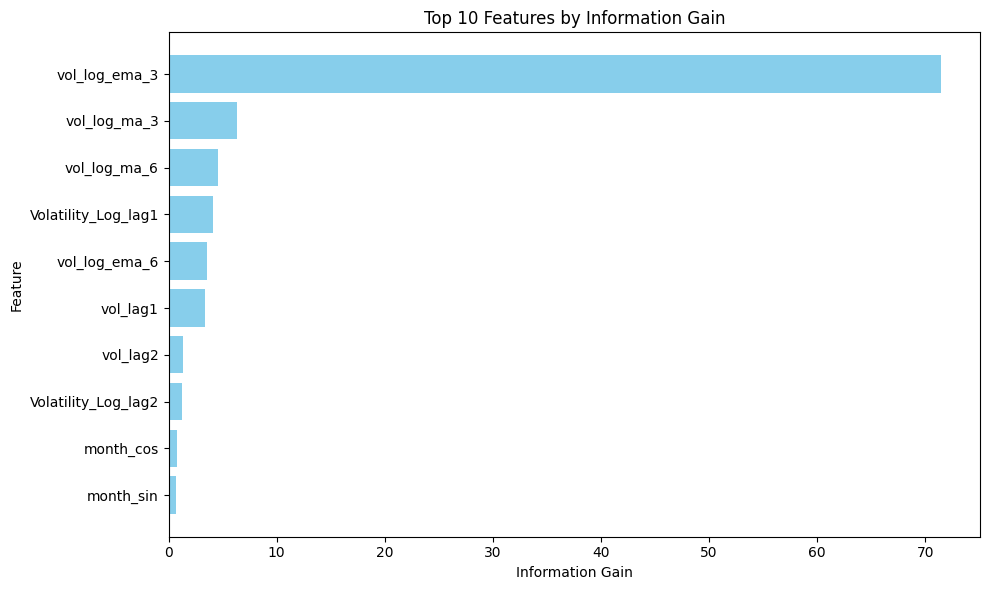

In [434]:
# -------------------------- 1. Load --------------------------

trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"

# -------------------------- 2. Time-Series Split --------------------------

allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[trainDf["Date"].isin(valDates)].copy()

xTrain = trainSet[featureCols]
yTrain = trainSet[targetCol]
xVal   = valSet[featureCols]
yVal   = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. CatBoost Hyperparameter Search --------------------------

paramDist = {
    "iterations": [500, 1000],
    "learning_rate": [0.01, 0.03],
    "depth": [6, 8, 10],
    "l2_leaf_reg": [1, 3, 5],
    "min_data_in_leaf": [3, 5, 10],
    "bagging_temperature": [0, 0.5, 1]
}

tscv = TimeSeriesSplit(n_splits=2)

catModel = CatBoostRegressor(
    random_state=42,
    thread_count=-1,
    verbose=0,
    cat_features=["Stock"]
)

randomSearch = RandomizedSearchCV(
    estimator=catModel,
    param_distributions=paramDist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit with early stopping via eval_set
randomSearch.fit(
    xTrain, yTrain,
    eval_set=(xVal, yVal),
    early_stopping_rounds=50,
    verbose=False
)

bestModel = randomSearch.best_estimator_

# -------------------------- 4. Validation --------------------------

valPredLog = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
cbValRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print(f"CATBOOST REGRESSOR RESULT")
print(f"{'='*50}")
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {cbValRmse:.6f}")
print(f"{'='*50}")

# -------------------------- 5. Feature Importance --------------------------

print("\n" + "="*50)
print("TOP FEATURES BY INFORMATION GAIN")
print("="*50)

# Re-fit best model on FULL training data (optional, but gives best importance)
bestModel.fit(xTrain, yTrain)  # already fitted in search, but safe to re-run

# Get feature importance (gain = total reduction in loss from splits on this feature)
importances = bestModel.feature_importances_
featureNames = xTrain.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': featureNames,
    'Gain': importances
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Show top 20
print(importance_df.head(20).to_string(index=False))

# -------------------------- 6. Volatility Prediction --------------------------
submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        row = trainDf[featureCols].median(numeric_only=True)
        row["Stock"] = stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")
xSubmit = latestDf[featureCols]

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date": submitDate,
    "Stock": submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 7. Results --------------------------

outPath = "A1_stock_volatility_submission.csv"
submission.to_csv(outPath, index=False)
print(f"\nSubmission saved → {outPath}")
print(submission.head(10))

# -------------------------- 8. Results --------------------------

plot_top_features(importance_df, feature_col='Feature', gain_col='Gain', top_n=10)

## Random Forest Model

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits
TOP FEATURES BY INFORMATION GAIN
                 Feature     Gain
           vol_log_ema_3 0.859213
           vol_log_ema_6 0.068997
            vol_log_ma_3 0.020438
                vol_lag1 0.014729
     Volatility_Log_lag1 0.014685
            vol_log_ma_6 0.006008
     Volatility_Log_lag2 0.002630
                vol_lag2 0.002540
                  Return 0.002539
             Return_lag2 0.000644
             Return_ma_3 0.000631
             Return_lag3 0.000461
     Volatility_Log_lag3 0.000417
                vol_lag3 0.000399
             Return_lag1 0.000350
               month_cos 0.000299
               month_sin 0.000260
                     EPS 0.000205
     Investing Cash Flow 0.000201
Investing Cash Flow_lag1 0.000199
RANDOM FOREST REGRESSOR RESULT
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_depth': 20, 'bootstrap': True}

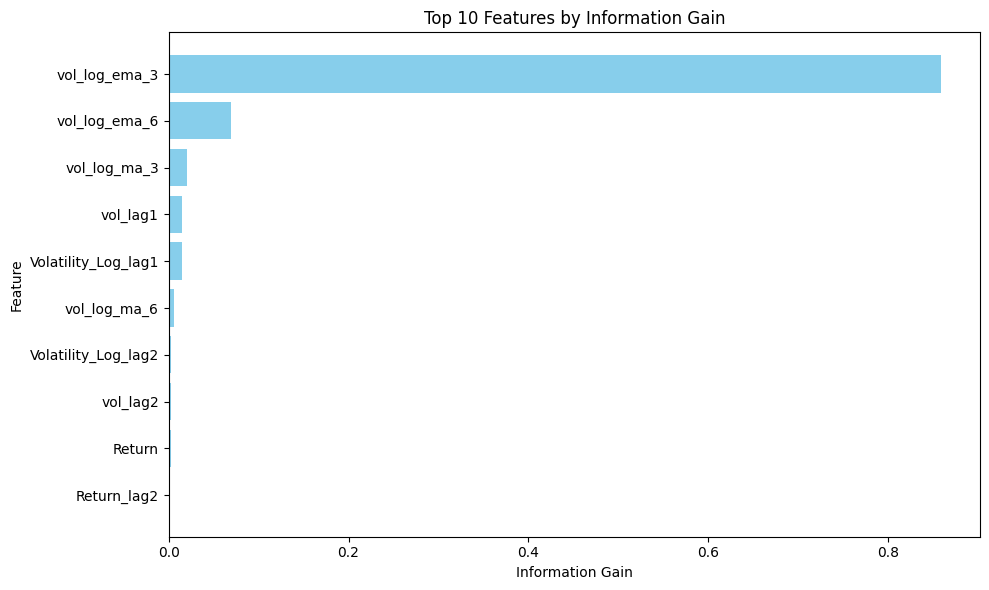

In [435]:
# -------------------------- 1. Load --------------------------
trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"

categoricalCols = ["Stock"]
numericCols = [col for col in featureCols if col not in categoricalCols]

# -------------------------- 2. Time-Series Split --------------------------
allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[trainDf["Date"].isin(valDates)].copy()

xTrainRaw = trainSet[featureCols]
yTrain = trainSet[targetCol]
xValRaw = valSet[featureCols]
yVal = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. Preprocessing --------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numericCols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricalCols)
    ]
)

xTrain = preprocessor.fit_transform(xTrainRaw)
xVal = preprocessor.transform(xValRaw)

# === You already built this — use it! ===
feature_names = numericCols + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(categoricalCols)
)

# -------------------------- 4. Random Forest Hyperparameter Search --------------------------

paramDist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", 0.7, 0.9],
    "bootstrap": [True, False]
}

tscv = TimeSeriesSplit(n_splits=2)

rfModel = RandomForestRegressor(random_state=42, n_jobs=-1)

randomSearch = RandomizedSearchCV(
    estimator=rfModel,
    param_distributions=paramDist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=1,
    random_state=42
)

randomSearch.fit(xTrain, yTrain)
bestModel = randomSearch.best_estimator_

# -------------------------- 4.5 Feature Importance (Information Gain) --------------------------
print("="*50)
print("TOP FEATURES BY INFORMATION GAIN")
print("="*50)

bestModel.fit(xTrain, yTrain)

importances = bestModel.feature_importances_
featureNames = feature_names

importance_df = pd.DataFrame({
    'Feature': featureNames,
    'Gain': importances
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

print(importance_df.head(20).to_string(index=False))

# -------------------------- 5. Validation --------------------------
import numpy as np
from sklearn.metrics import mean_squared_error

valPredLog = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
rfValRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print(f"RANDOM FOREST REGRESSOR RESULT")
print(f"{'='*50}")
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {rfValRmse:.6f}")
print(f"{'='*50}")

# -------------------------- 7. Volatility Prediction --------------------------
submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        row = trainDf[numericCols].median(numeric_only=True).to_dict()
        row["Stock"] = stock
        for col in featureCols:
            if col not in row:
                row[col] = 0 if col in numericCols else stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")

for col in featureCols:
    if col not in latestDf.columns:
        latestDf[col] = 0

xSubmit = preprocessor.transform(latestDf[featureCols])

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date": submitDate,
    "Stock": submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 8. Results --------------------------
print(submission.head(10))

# -------------------------- 9. Plot Feature Information Gain --------------------------
plot_top_features(importance_df, feature_col='Feature', gain_col='Gain', top_n=10)

In [436]:
# RMSE Result Summary
print("\n--- RMSE Summary ---")
print(f"LIGHTGBM RMSE: {lgbRmse:.6f}")
print(f"CATBOOST RMSE: {cbValRmse:.6f}")
print(f"RANDOM FOREST RMSE: {rfValRmse:.6f}")


--- RMSE Summary ---
LIGHTGBM RMSE: 0.343815
CATBOOST RMSE: 0.204545
RANDOM FOREST RMSE: 0.250708


# References

https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0